In [1]:
import os
import shutil
import random
import csv

def dump_random_samples(loader, num_samples, target_dir):
    """
    Dump random samples from a DataLoader into a target directory.

    Args:
        loader (DataLoader): The DataLoader containing the dataset.
        num_samples (int): The number of random samples to dump.
        target_dir (str): The directory where the samples will be dumped.
    """
    # Create target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Create a CSV file to store image paths and labels
    csv_path = os.path.join(target_dir, "labels.csv")
    with open(csv_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['image_path', 'label'])

        # Counter to keep track of dumped samples
        samples_dumped = 0

        # Iterate over the loader
        for batch_idx, (images, labels) in enumerate(loader):
            # Iterate over the batch
            for i in range(len(images)):
                # Check if we have dumped the desired number of samples
                if samples_dumped >= num_samples:
                    return target_dir

                # Get a random image from the batch
                image = images[i]
                label = labels[i].item()

                # Define the target file path
                target_file_path = os.path.join(target_dir, f"sample_{samples_dumped}.png")

                # Save the image to the target directory
                torchvision.utils.save_image(image, target_file_path)

                # Write image path and label to the CSV file
                csv_writer.writerow([target_file_path, label])

                # Increment the counter
                samples_dumped += 1

    return target_dir

In [3]:
import requests
import zipfile
import os

# URL of the dataset
url = 'https://www.dropbox.com/scl/fi/u2w4eoeiksyae1pn0di6d/IndianSignLanguage.zip?rlkey=38ztp9zkqvhdvusoeet3a9qex&dl=1'  # Set dl=1 to download directly

# Download the file
response = requests.get(url)
zip_path = 'IndianSignLanguage.zip'

# Save the ZIP file
with open(zip_path, 'wb') as f:
    f.write(response.content)

print("Dataset downloaded successfully.")

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('IndianSignLanguage')

print("Dataset extracted successfully.")


Dataset downloaded successfully.
Dataset extracted successfully.


In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
import shutil
import seaborn as sns
import bs4
import warnings
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning
# Suppress the warning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to load the dataset and extract metadata
def extract_metadata(dataset_path):
    data = []
    class_distribution = {}

    # Loop through each class directory
    for class_dir in os.listdir(dataset_path):
        # Skip hidden files or directories (e.g., .DS_Store on macOS)
        if class_dir.startswith('.'):
            continue

        # Use the directory name as the class label (no conversion to int)
        class_id = class_dir
        class_images = os.listdir(os.path.join(dataset_path, class_dir))

        # Count the number of images in the class directory
        class_distribution[class_id] = len(class_images)
        data.append((class_id, len(class_images)))

    # Convert data to DataFrame for easier manipulation and visualization
    df = pd.DataFrame(data, columns=['ClassID', 'NumImages'])

    # Calculate total number of images
    total_images = df['NumImages'].sum()

    # Display metadata
    print("Metadata Summary:")
    print("=================")
    print("Total number of images:", total_images)
    print("Number of classes:", len(df))
    print("Class distribution:")
    print(df)
    print("")

    return df, class_distribution

# Path to the dataset
dataset_path = "IndianSignLanguage/data"

# Extract metadata
metadata_df, class_distribution = extract_metadata(dataset_path)


Metadata Summary:
Total number of images: 42000
Number of classes: 35
Class distribution:
   ClassID  NumImages
0        P       1200
1        Z       1200
2        D       1200
3        F       1200
4        I       1200
5        4       1200
6        1       1200
7        R       1200
8        X       1200
9        K       1200
10       S       1200
11       J       1200
12       6       1200
13       7       1200
14       9       1200
15       T       1200
16       5       1200
17       Y       1200
18       V       1200
19       3       1200
20       C       1200
21       2       1200
22       B       1200
23       E       1200
24       G       1200
25       U       1200
26       H       1200
27       Q       1200
28       N       1200
29       A       1200
30       M       1200
31       L       1200
32       O       1200
33       8       1200
34       W       1200



In [7]:
import os
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Define paths
source_dir = "IndianSignLanguage/data"
target_dir = "IndianSignLanguage_processed"

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Define classes to keep (adjust as needed for your dataset)
# Here, classes can be set as specific folder names you want to keep.
classes_to_keep = os.listdir(source_dir)  # Keeps all classes in the dataset

# Copy images of selected classes to the target directory
for class_name in classes_to_keep:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(target_dir, class_name)
    try:
        shutil.copytree(src_path, dst_path)
    except FileExistsError:
        print(f"Directory '{dst_path}' already exists. Skipping copying.")

# Dataset Paths
data_dir = target_dir

# Extract metadata
# Exploratory Analysis
print("Exploratory Analysis:")
metadata_df, class_distribution = extract_metadata(data_dir)

# Image transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with augmented transform
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Convert to DataFrame
df = pd.DataFrame(dataset.imgs, columns=['image_path', 'label'])


# Load dataset
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Directory 'IndianSignLanguage_processed/P' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/Z' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/D' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/F' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/I' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/4' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/1' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/R' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/X' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/K' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/S' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/J' already exists. Skipping copying.
Directory 'IndianSignLanguage_processed/6' already exists. Skipping copying.

In [8]:
from google.colab import files

def zip_and_download(directory_path):
    """
    Create a zip file of a directory and download it.

    Args:
        directory_path (str): The path to the directory to be zipped and downloaded.
    """
    zip_file_path = f"{directory_path}.zip"
    !zip -r $zip_file_path $directory_path
    files.download(zip_file_path)

In [9]:
# Example usage:
# Assuming val_loader is your validation DataLoader
target_directory = dump_random_samples(train_loader, 100, "random_samples_IndianSignLanguage")
# Example usage:
# Assuming target_directory is the path to the directory containing dumped samples
zip_and_download(target_directory)

  adding: random_samples_IndianSignLanguage/ (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_19.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_70.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_90.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_25.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_29.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_78.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_73.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_10.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_64.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_49.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_51.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_21.png (stored 0%)
  adding: random_samples_IndianSignLanguage/sample_17.png (stored 0%)
  adding: random_samples_IndianSi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import requests
import zipfile
import os

# URL of the dataset with direct download
url = 'https://www.dropbox.com/scl/fi/7o8eil59unj7vsxws6zgo/Sign-Language-Digits-Dataset-master-1.zip?rlkey=l3hrprqn03ts03ulbth2216w0&st=c1k4gdpw&dl=1'

# Download the file
response = requests.get(url)

# Check if the response is successful
if response.status_code == 200:
    zip_path = 'Sign-Language-Digits-Dataset-master.zip'

    # Save the ZIP file
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    print("Dataset downloaded successfully.")

    # Verify if the file is a valid zip file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.testzip()  # Test the zip file integrity
            zip_ref.extractall('Sign-Language-Digits-Dataset-master')
            print("Dataset extracted successfully.")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid zip file.")
else:
    print(f"Error downloading the dataset. Status code: {response.status_code}")


Dataset downloaded successfully.
Dataset extracted successfully.


Metadata Summary:
Total number of images: 2062
Number of classes: 10
Class distribution:
  ClassID  NumImages
0       4        207
1       1        206
2       0        205
3       6        207
4       7        206
5       9        204
6       5        207
7       3        206
8       2        206
9       8        208



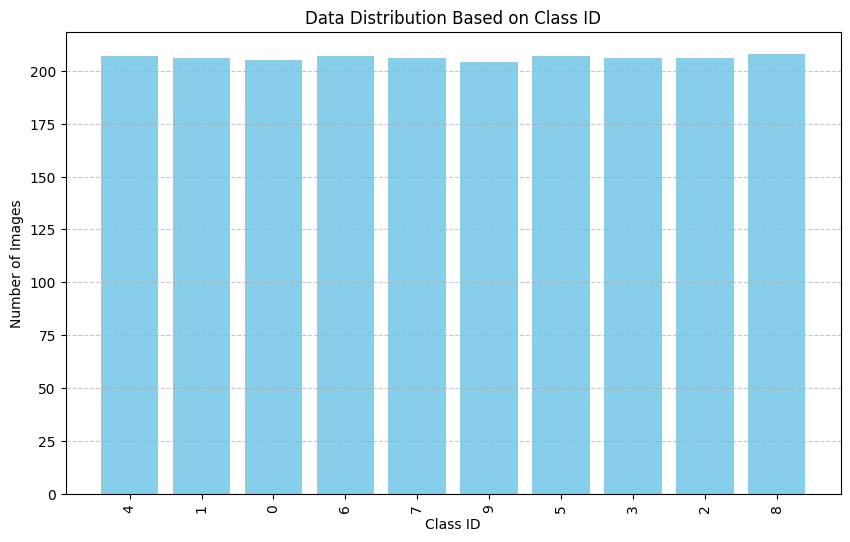

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to load the dataset and extract metadata
def extract_metadata(dataset_path):
    data = []
    class_distribution = {}

    # Loop through each class directory
    for class_dir in os.listdir(dataset_path):
        # Skip hidden files or directories (e.g., .DS_Store on macOS)
        if class_dir.startswith('.'):
            continue

        # Use the directory name as the class label (no conversion to int)
        class_id = class_dir
        class_images = os.listdir(os.path.join(dataset_path, class_dir))

        # Count the number of images in the class directory
        class_distribution[class_id] = len(class_images)
        data.append((class_id, len(class_images)))

    # Convert data to DataFrame for easier manipulation and visualization
    df = pd.DataFrame(data, columns=['ClassID', 'NumImages'])

    # Calculate total number of images
    total_images = df['NumImages'].sum()

    # Display metadata
    print("Metadata Summary:")
    print("=================")
    print("Total number of images:", total_images)
    print("Number of classes:", len(df))
    print("Class distribution:")
    print(df)
    print("")

    return df, class_distribution

# Path to the dataset
dataset_path = "Sign-Language-Digits-Dataset-master/Sign-Language-Digits-Dataset-master/Dataset"

# Extract metadata
metadata_df, class_distribution = extract_metadata(dataset_path)

# Plot the data distribution based on class ID
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Data Distribution Based on Class ID')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many classes
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Exploratory Analysis:
Metadata Summary:
Total number of images: 2062
Number of classes: 10
Class distribution:
  ClassID  NumImages
0       4        207
1       1        206
2       0        205
3       6        207
4       7        206
5       9        204
6       5        207
7       3        206
8       2        206
9       8        208



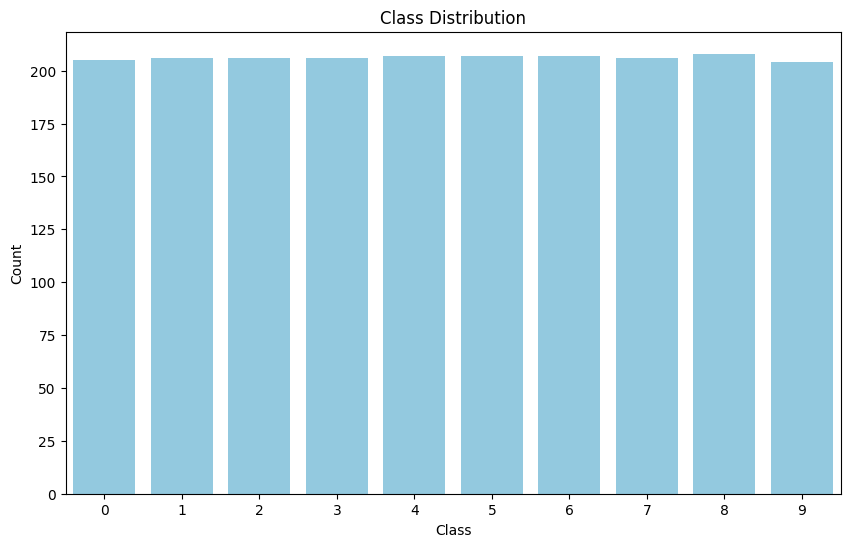

In [13]:
import os
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Define paths
source_dir = "Sign-Language-Digits-Dataset-master/Sign-Language-Digits-Dataset-master/Dataset"
target_dir = "Sign-Language-Digits-Dataset-master_processed"

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Define classes to keep (adjust as needed for your dataset)
# Here, classes can be set as specific folder names you want to keep.
classes_to_keep = os.listdir(source_dir)  # Keeps all classes in the dataset

# Copy images of selected classes to the target directory
for class_name in classes_to_keep:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(target_dir, class_name)
    try:
        shutil.copytree(src_path, dst_path)
    except FileExistsError:
        print(f"Directory '{dst_path}' already exists. Skipping copying.")

# Dataset Paths
data_dir = target_dir

# Extract metadata
# Exploratory Analysis
print("Exploratory Analysis:")
metadata_df, class_distribution = extract_metadata(data_dir)

# Image transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with augmented transform
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Convert to DataFrame
df = pd.DataFrame(dataset.imgs, columns=['image_path', 'label'])

# Distribution Graphs
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import pandas as pd
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [15]:
# Set the random seed
# torch.manual_seed(42)
# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# Example usage:
# Assuming val_loader is your validation DataLoader
target_directory = dump_random_samples(train_loader, 100, "random_samples_SignLanguageDigits")
# Example usage:
# Assuming target_directory is the path to the directory containing dumped samples
zip_and_download(target_directory)

  adding: random_samples_SignLanguageDigits/ (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_19.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_70.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_90.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_25.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_29.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_78.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_73.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_10.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_64.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_49.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_51.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_21.png (stored 0%)
  adding: random_samples_SignLanguageDigits/sample_17.png (stored 0%)
  adding: random_samples_SignLang

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import requests
import zipfile
import os

# URL of the dataset with direct download
url = 'https://www.dropbox.com/scl/fi/n7ydj4yvfbasbztdii981/HandGesture.zip?rlkey=6go8qgavxyu457459tqcqjg87&st=m6qw81ee&dl=1'

# Download the file
response = requests.get(url)

# Check if the response is successful
if response.status_code == 200:
    zip_path = 'HandGesture.zip'

    # Save the ZIP file
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    print("Dataset downloaded successfully.")

    # Check the first few bytes to verify it's a zip file
    if response.content[:4] == b'PK\x03\x04':  # The first bytes of a zip file
        print("Valid ZIP file detected.")

        # Verify if the file is a valid zip file
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.testzip()  # Test the zip file integrity
                zip_ref.extractall('HandGesture')
                print("Dataset extracted successfully.")
        except zipfile.BadZipFile:
            print("Error: The file is not a valid zip file.")
    else:
        print("Error: The file does not appear to be a valid ZIP file.")
else:
    print(f"Error downloading the dataset. Status code: {response.status_code}")


Dataset downloaded successfully.
Valid ZIP file detected.
Dataset extracted successfully.


Metadata Summary:
Total number of images: 3259
Number of classes: 2
Class distribution:
      ClassID  NumImages
0  thumbsdown       1641
1    thumbsup       1618



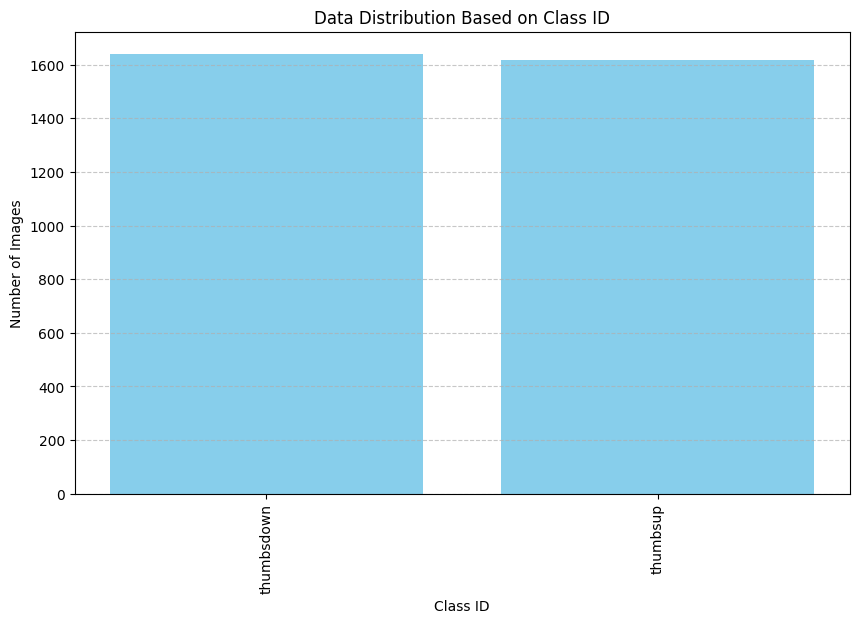

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function to load the dataset and extract metadata
def extract_metadata(dataset_path):
    data = []
    class_distribution = {}

    # Loop through each class directory
    for class_dir in os.listdir(dataset_path):
        # Skip hidden files or directories (e.g., .DS_Store on macOS)
        if class_dir.startswith('.'):
            continue

        # Use the directory name as the class label (no conversion to int)
        class_id = class_dir
        class_images = os.listdir(os.path.join(dataset_path, class_dir))

        # Count the number of images in the class directory
        class_distribution[class_id] = len(class_images)
        data.append((class_id, len(class_images)))

    # Convert data to DataFrame for easier manipulation and visualization
    df = pd.DataFrame(data, columns=['ClassID', 'NumImages'])

    # Calculate total number of images
    total_images = df['NumImages'].sum()

    # Display metadata
    print("Metadata Summary:")
    print("=================")
    print("Total number of images:", total_images)
    print("Number of classes:", len(df))
    print("Class distribution:")
    print(df)
    print("")

    return df, class_distribution

# Path to the dataset
dataset_path = "HandGesture/data"

# Extract metadata
metadata_df, class_distribution = extract_metadata(dataset_path)

# Plot the data distribution based on class ID
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Data Distribution Based on Class ID')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many classes
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Exploratory Analysis:
Metadata Summary:
Total number of images: 3259
Number of classes: 2
Class distribution:
      ClassID  NumImages
0  thumbsdown       1641
1    thumbsup       1618



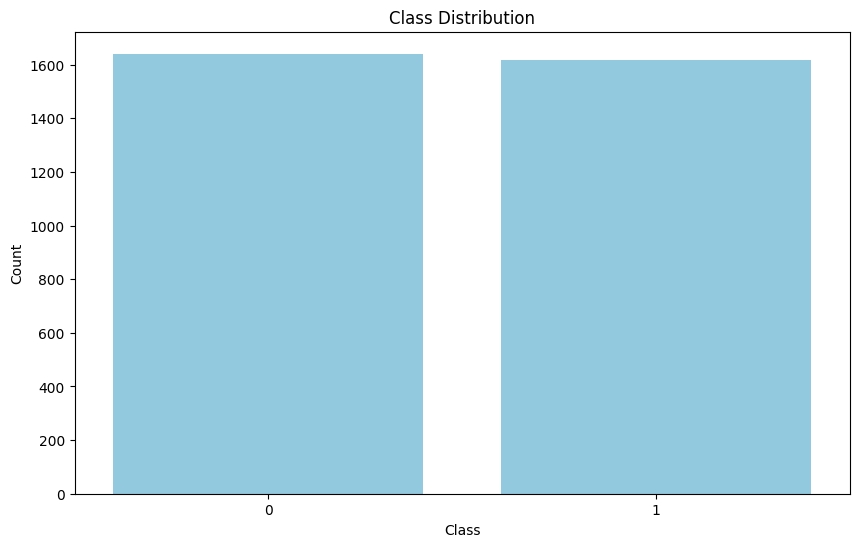

In [19]:
import os
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Define paths
source_dir = "HandGesture/data"
target_dir = "HandGesture_processed"

# Create target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Define classes to keep (adjust as needed for your dataset)
# Here, classes can be set as specific folder names you want to keep.
classes_to_keep = os.listdir(source_dir)  # Keeps all classes in the dataset

# Copy images of selected classes to the target directory
for class_name in classes_to_keep:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(target_dir, class_name)
    try:
        shutil.copytree(src_path, dst_path)
    except FileExistsError:
        print(f"Directory '{dst_path}' already exists. Skipping copying.")

# Dataset Paths
data_dir = target_dir

# Extract metadata
# Exploratory Analysis
print("Exploratory Analysis:")
metadata_df, class_distribution = extract_metadata(data_dir)

# Image transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset with augmented transform
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Convert to DataFrame
df = pd.DataFrame(dataset.imgs, columns=['image_path', 'label'])

# Distribution Graphs
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [20]:
# Set the random seed
# torch.manual_seed(42)
# Split dataset into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
# Example usage:
# Assuming val_loader is your validation DataLoader
target_directory = dump_random_samples(train_loader, 100, "random_samples_HandGesture")
# Example usage:
# Assuming target_directory is the path to the directory containing dumped samples
zip_and_download(target_directory)

  adding: random_samples_HandGesture/ (stored 0%)
  adding: random_samples_HandGesture/sample_19.png (stored 0%)
  adding: random_samples_HandGesture/sample_70.png (stored 0%)
  adding: random_samples_HandGesture/sample_90.png (stored 0%)
  adding: random_samples_HandGesture/sample_25.png (stored 0%)
  adding: random_samples_HandGesture/sample_29.png (stored 0%)
  adding: random_samples_HandGesture/sample_78.png (stored 0%)
  adding: random_samples_HandGesture/sample_73.png (stored 0%)
  adding: random_samples_HandGesture/sample_10.png (stored 0%)
  adding: random_samples_HandGesture/sample_64.png (stored 0%)
  adding: random_samples_HandGesture/sample_49.png (stored 0%)
  adding: random_samples_HandGesture/sample_51.png (stored 0%)
  adding: random_samples_HandGesture/sample_21.png (stored 0%)
  adding: random_samples_HandGesture/sample_17.png (stored 0%)
  adding: random_samples_HandGesture/sample_81.png (stored 0%)
  adding: random_samples_HandGesture/sample_71.png (stored 0%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>